In [31]:
import h5py as h5
import numpy as np
import matplotlib.pylab as plt
import os

In [128]:
def Div(fx,fy,T,Nx,Ny):

    Fnx = Nx
    Fny = int(Ny*0.5) + 1
    
    Ffx = np.zeros((T,Fnx,Fny), dtype=complex)
    Ffy = np.zeros((T,Fnx,Fny), dtype=complex)
    for t in range(T):
        Ffx[t,:,:] = np.fft.rfftn(fx[t,:,:])
        Ffy[t,:,:] = np.fft.rfftn(fy[t,:,:])
    
    kx = np.zeros(Fnx, dtype=int) 
    ky = np.zeros(Fny, dtype=int)
    
    for i in range(0,Fny):
        kx[i]=i
        ky[i]=i
    for i in range(Fny,Fnx):
        kx[i]=-Fnx+i   

    I=0-1j; ''' COL MENO É GIUSTO '''
    
    div = np.zeros((T,Nx,Ny))
    for t in range(T):   
        div[t,:,:] = np.fft.irfftn( (ky*Ffy[t,:,:] + np.transpose((kx*np.transpose(Ffx[t,:,:],(1,0))),(1,0))*I ))
    
    return div

In [129]:
names=[]
arr = os.listdir('.')
for i in arr:
    if(i[0:6]=='output'): 
        names.append(int(i[6:-3]))
names.sort()
T = len(names)
for i in range(T):
    names[i] = "output" + str(names[i]) + ".h5"
print(names)

file = h5.File(names[0], "r"); d=0
for key in file.keys():
   d=d+1
   print('dataset %s = '%d,key)
Nx = int(file.attrs["NX"][0])
Ny = int(file.attrs["NY"][0])
print(Nx, Ny)
file.close()

rho = np.zeros((T,Nx,Ny))
ux = np.zeros_like(rho)
uy = np.zeros_like(rho)
for i in range(T):
    file = h5.File(names[i], "r")
    rho[i,:,:] = file.get("/rho")[...]
    ux[i,:,:] = file.get("/ux")[...]
    uy[i,:,:] = file.get("/uy")[...]
    file.close()

divV = Div(ux, uy, T, Nx, Ny)

['output0.h5', 'output1.h5', 'output2.h5', 'output3.h5', 'output4.h5', 'output5.h5', 'output6.h5', 'output7.h5', 'output8.h5', 'output9.h5', 'output10.h5']
dataset 1 =  rho
dataset 2 =  ux
dataset 3 =  uy
128 128


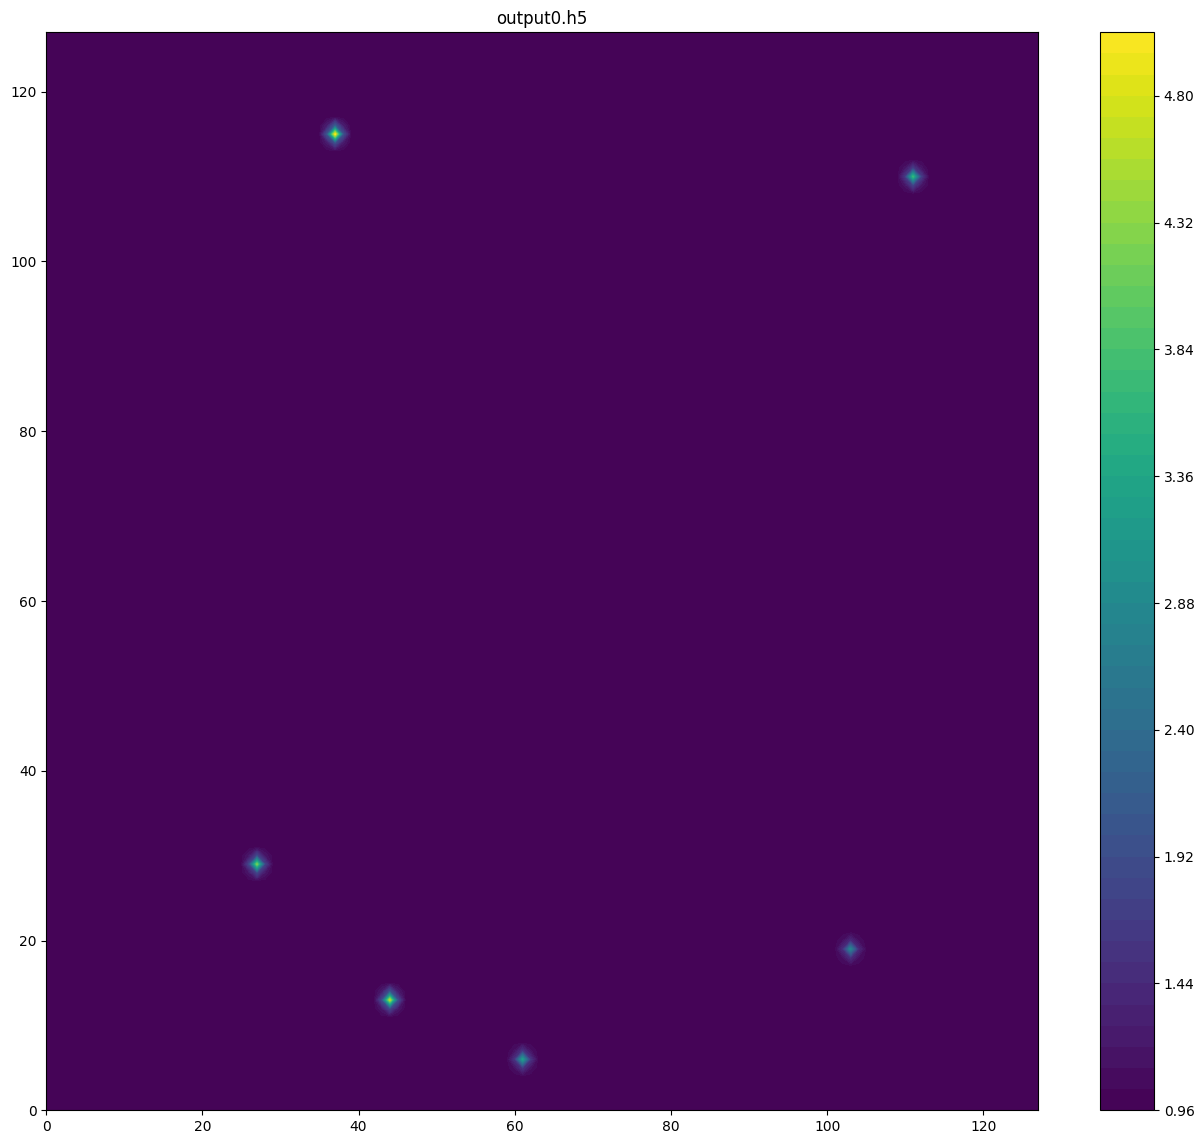

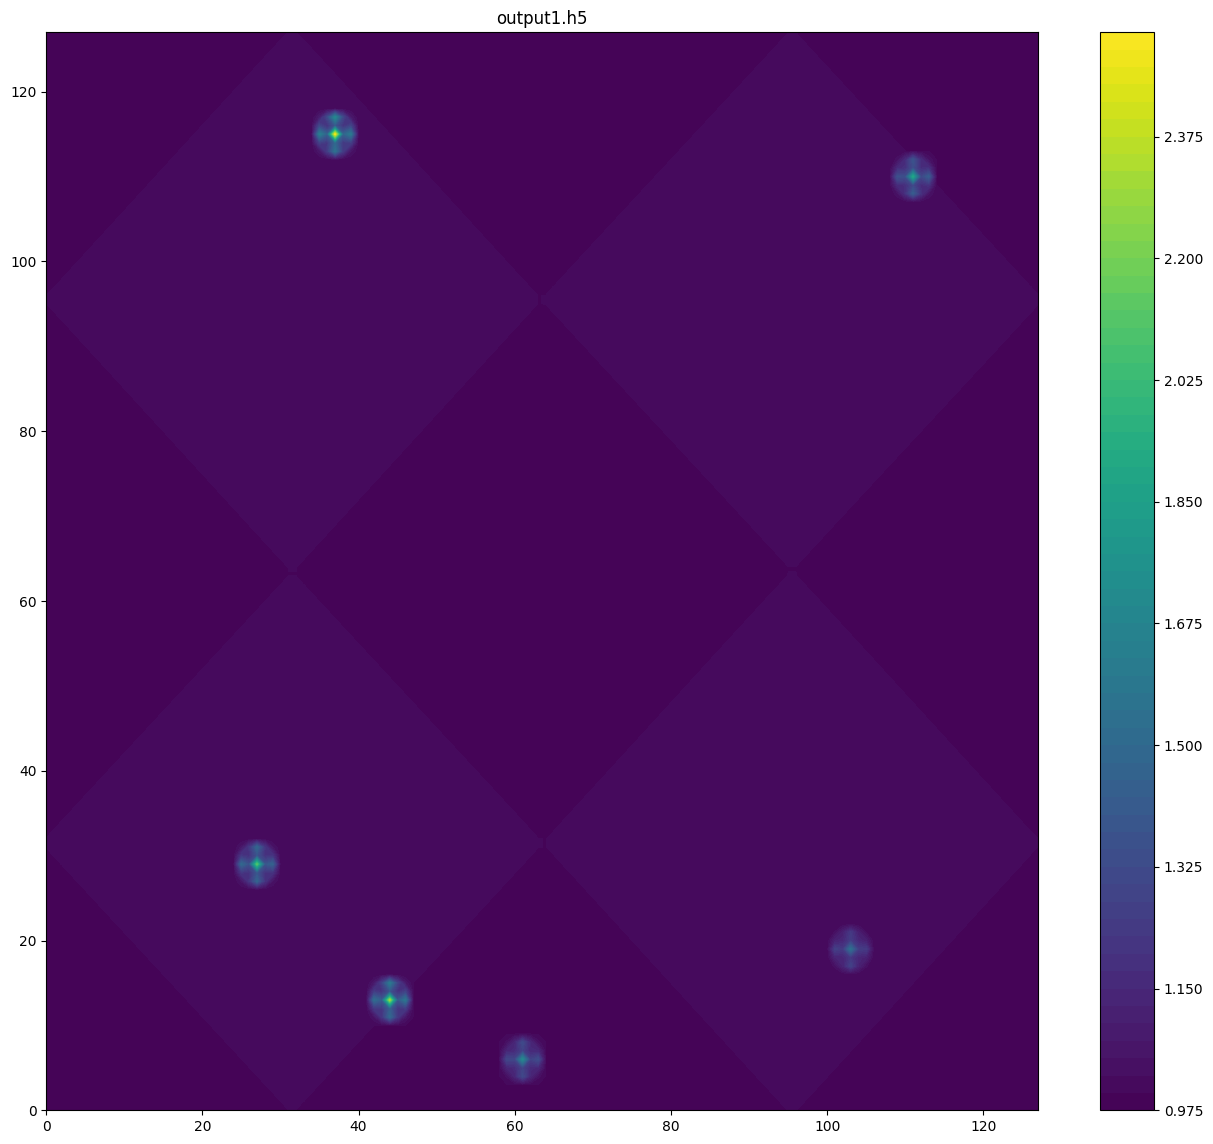

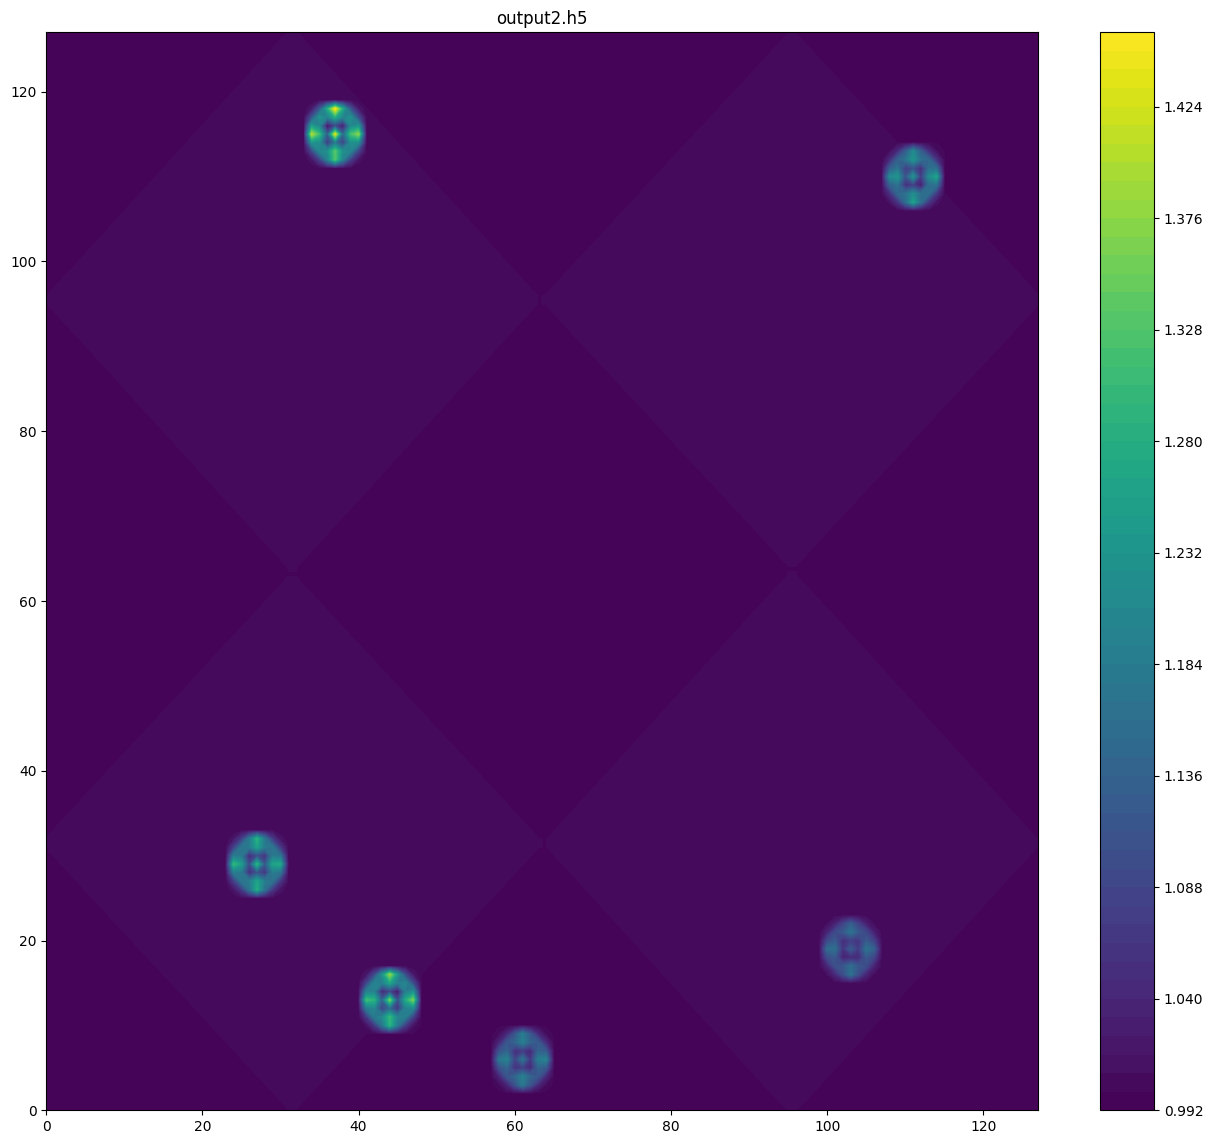

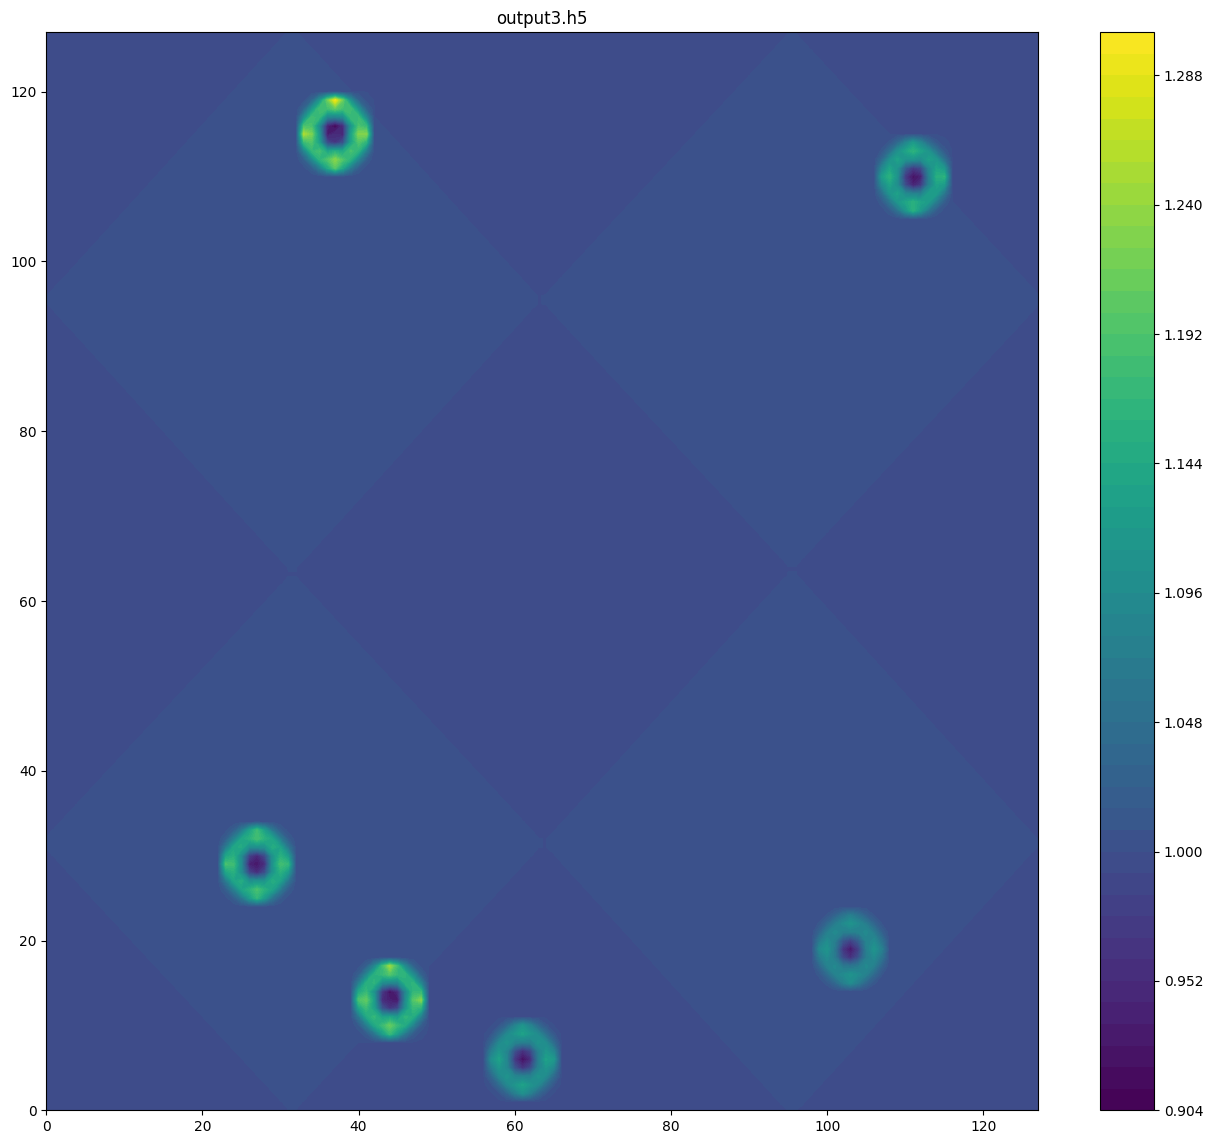

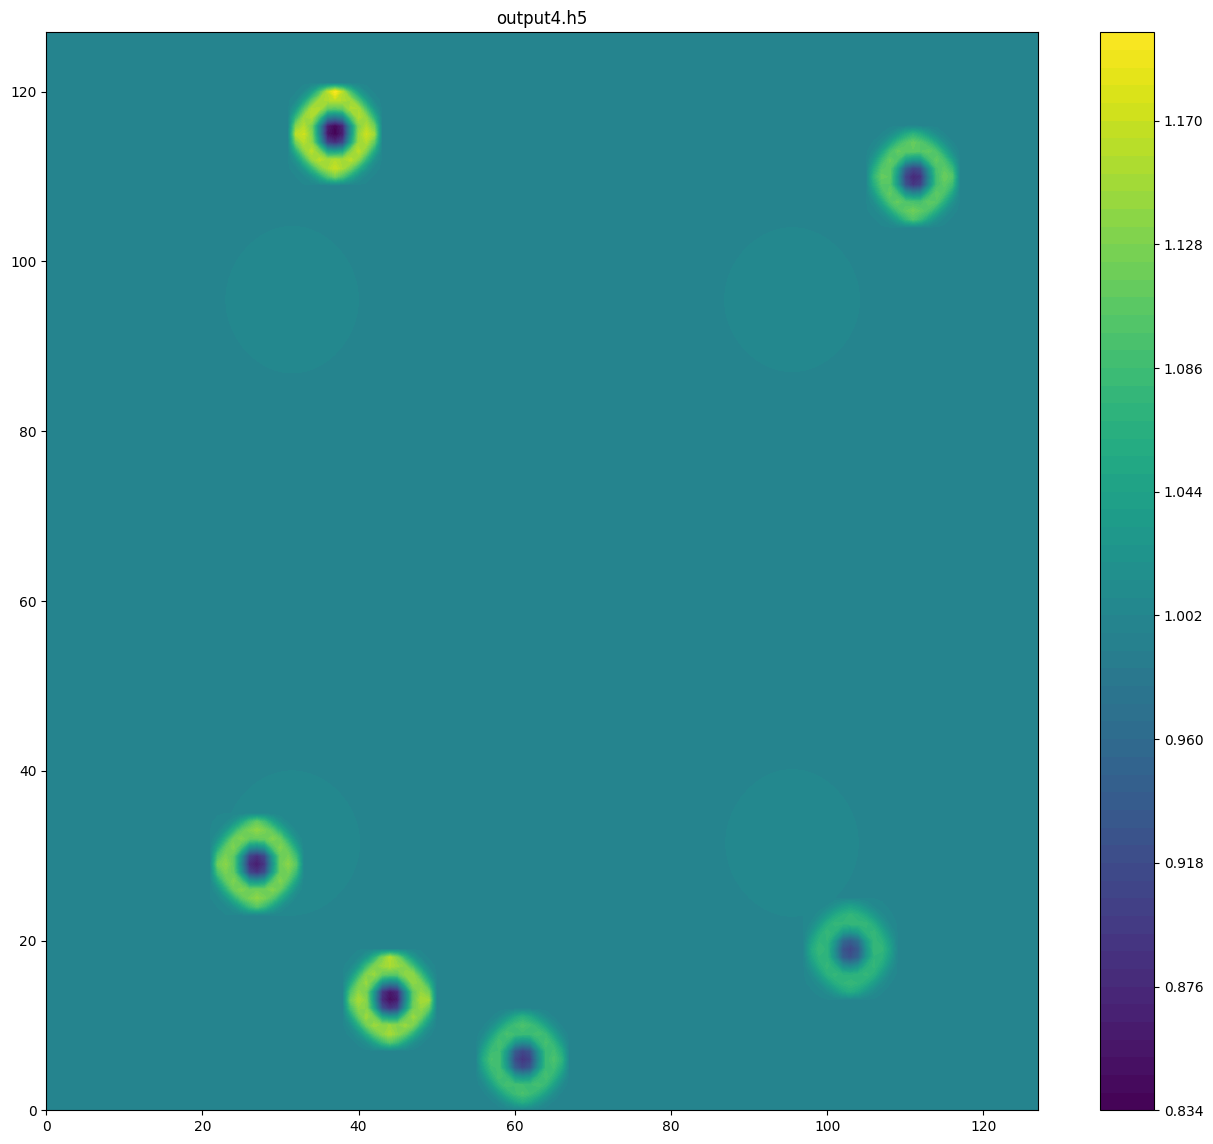

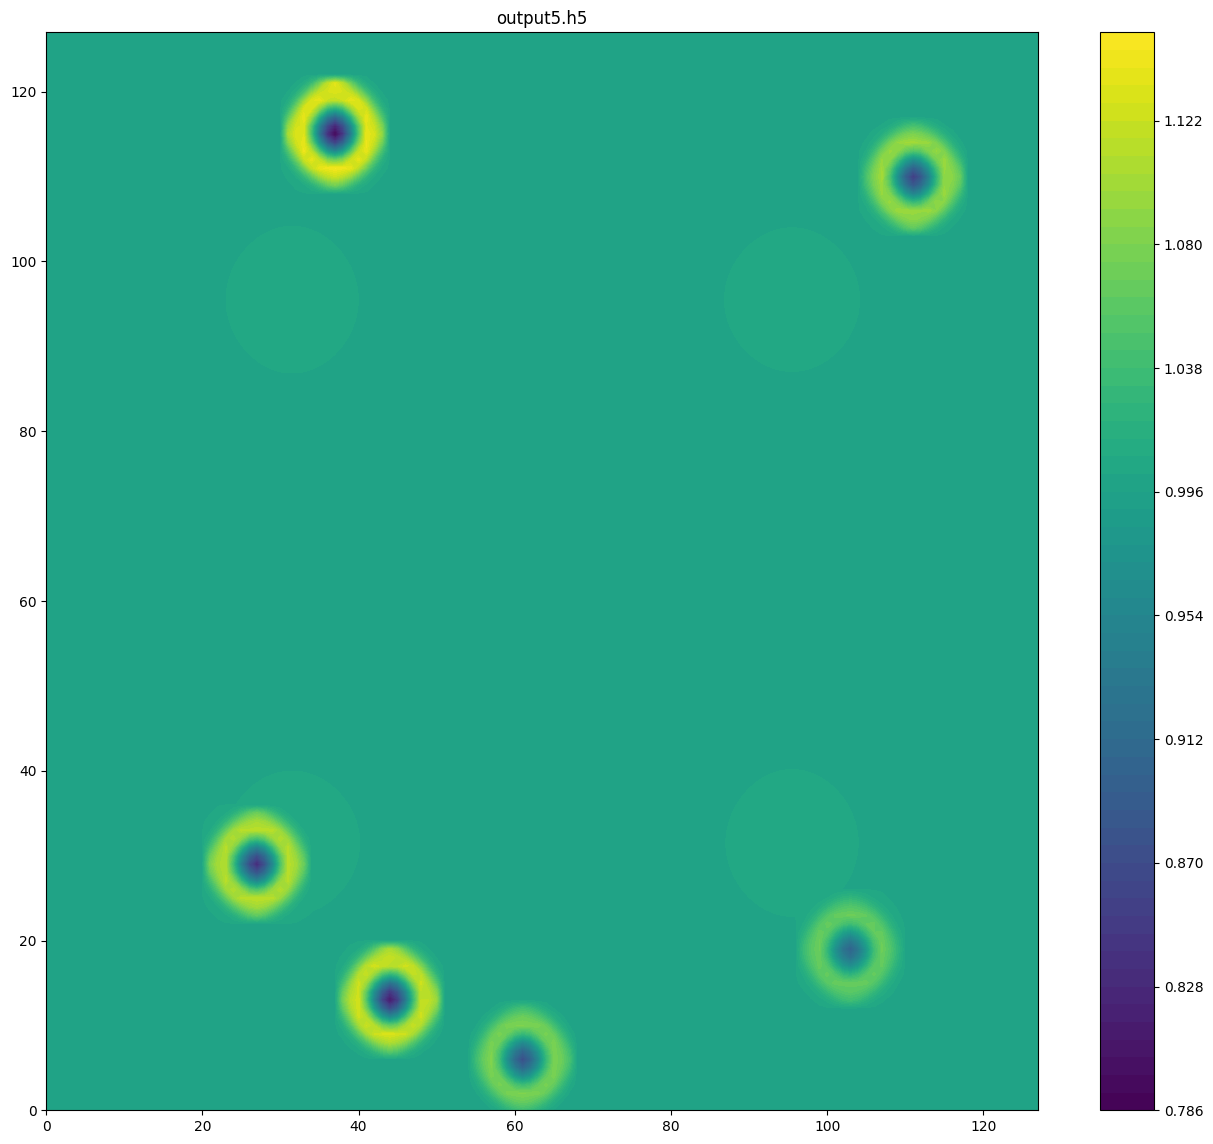

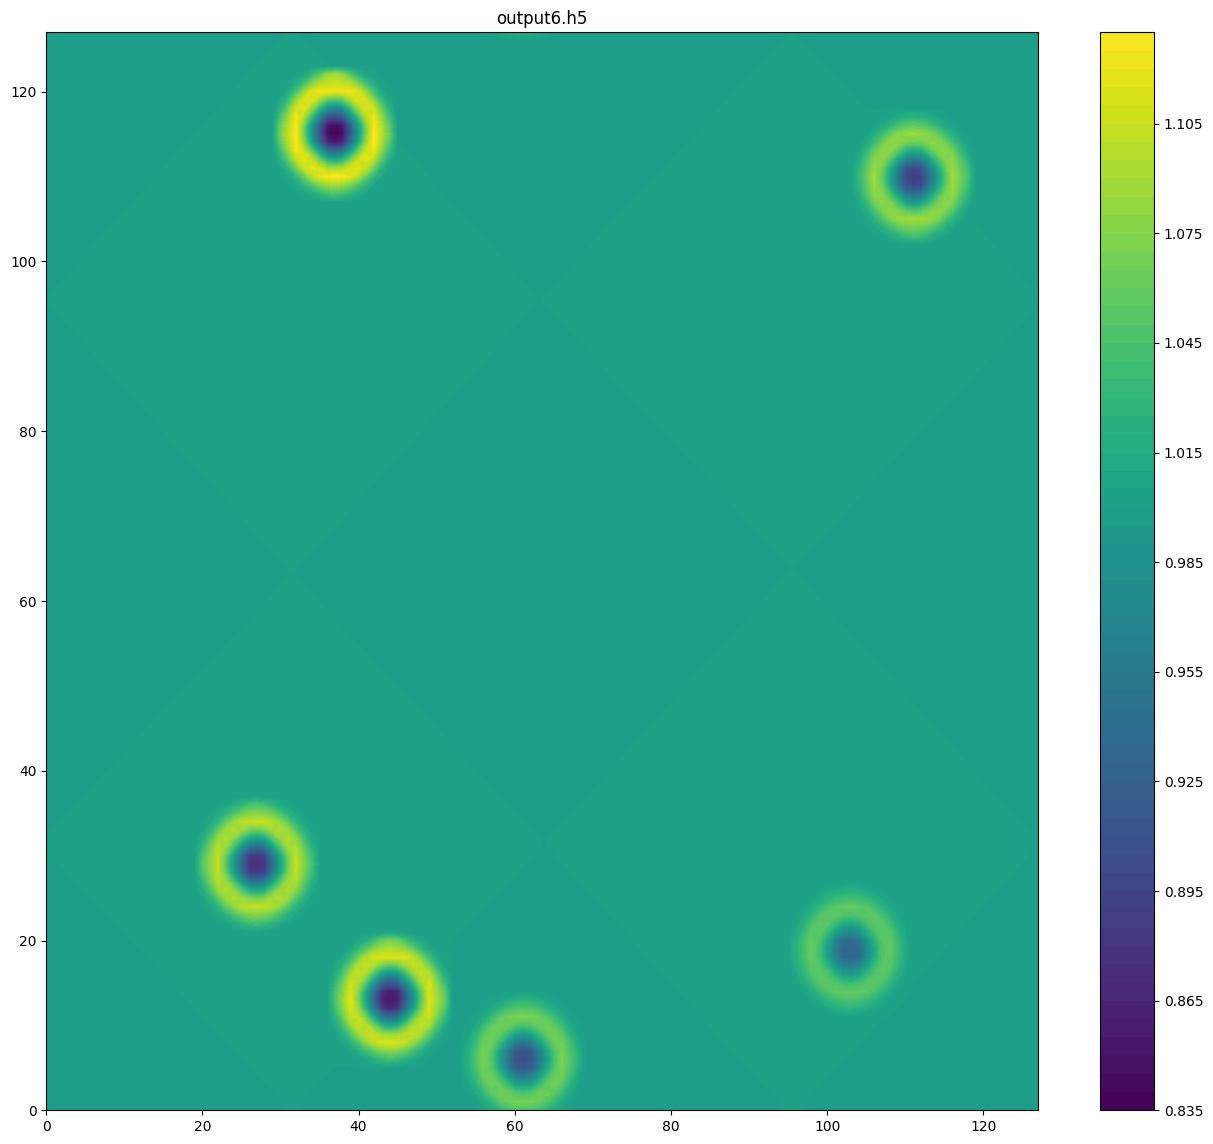

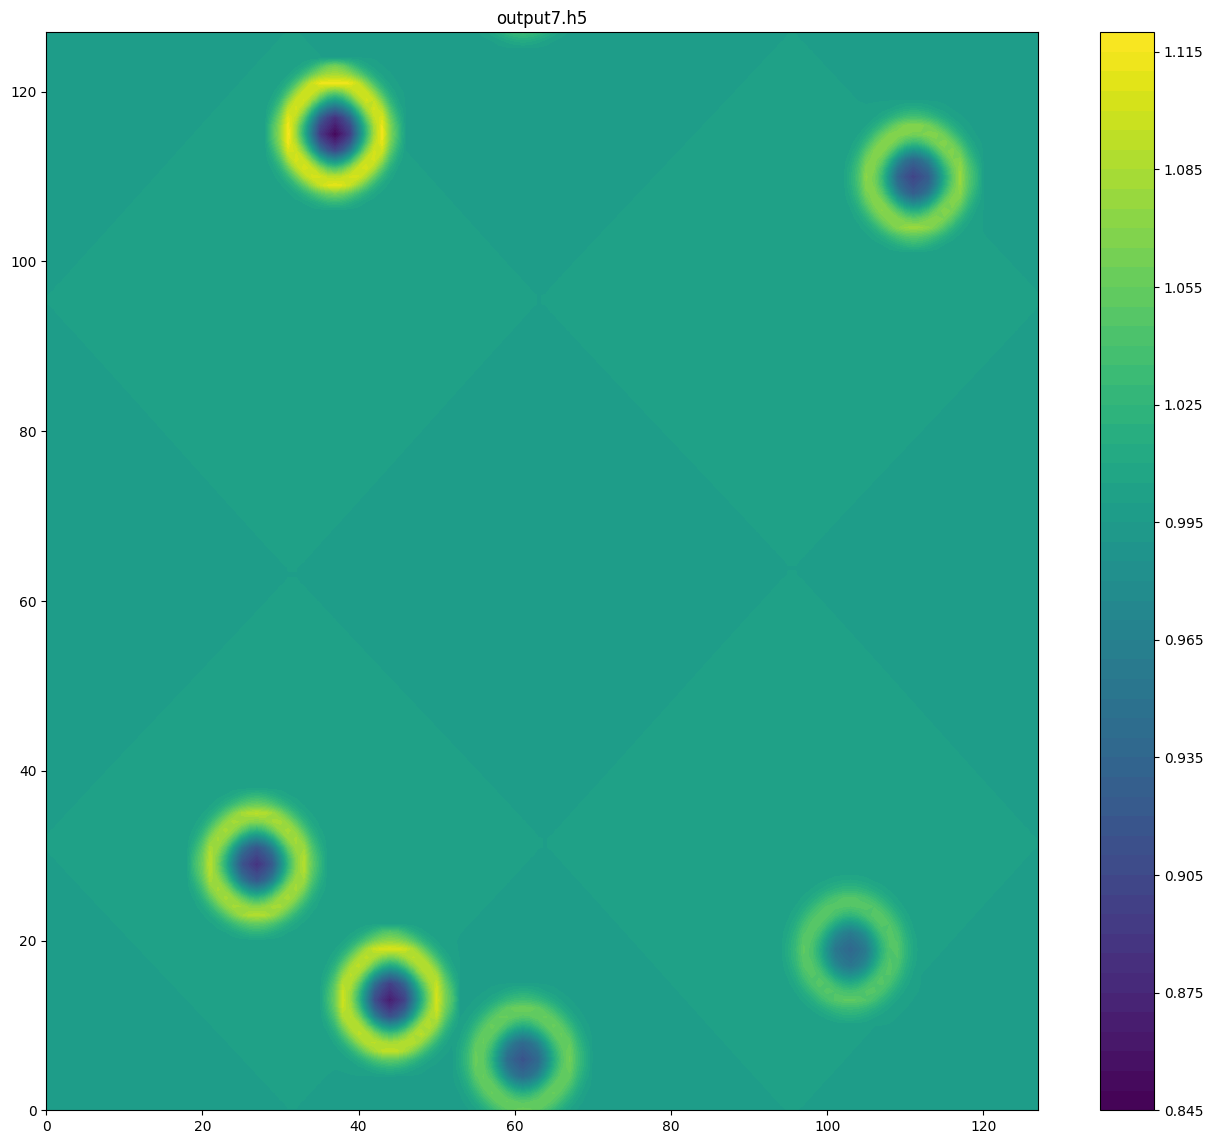

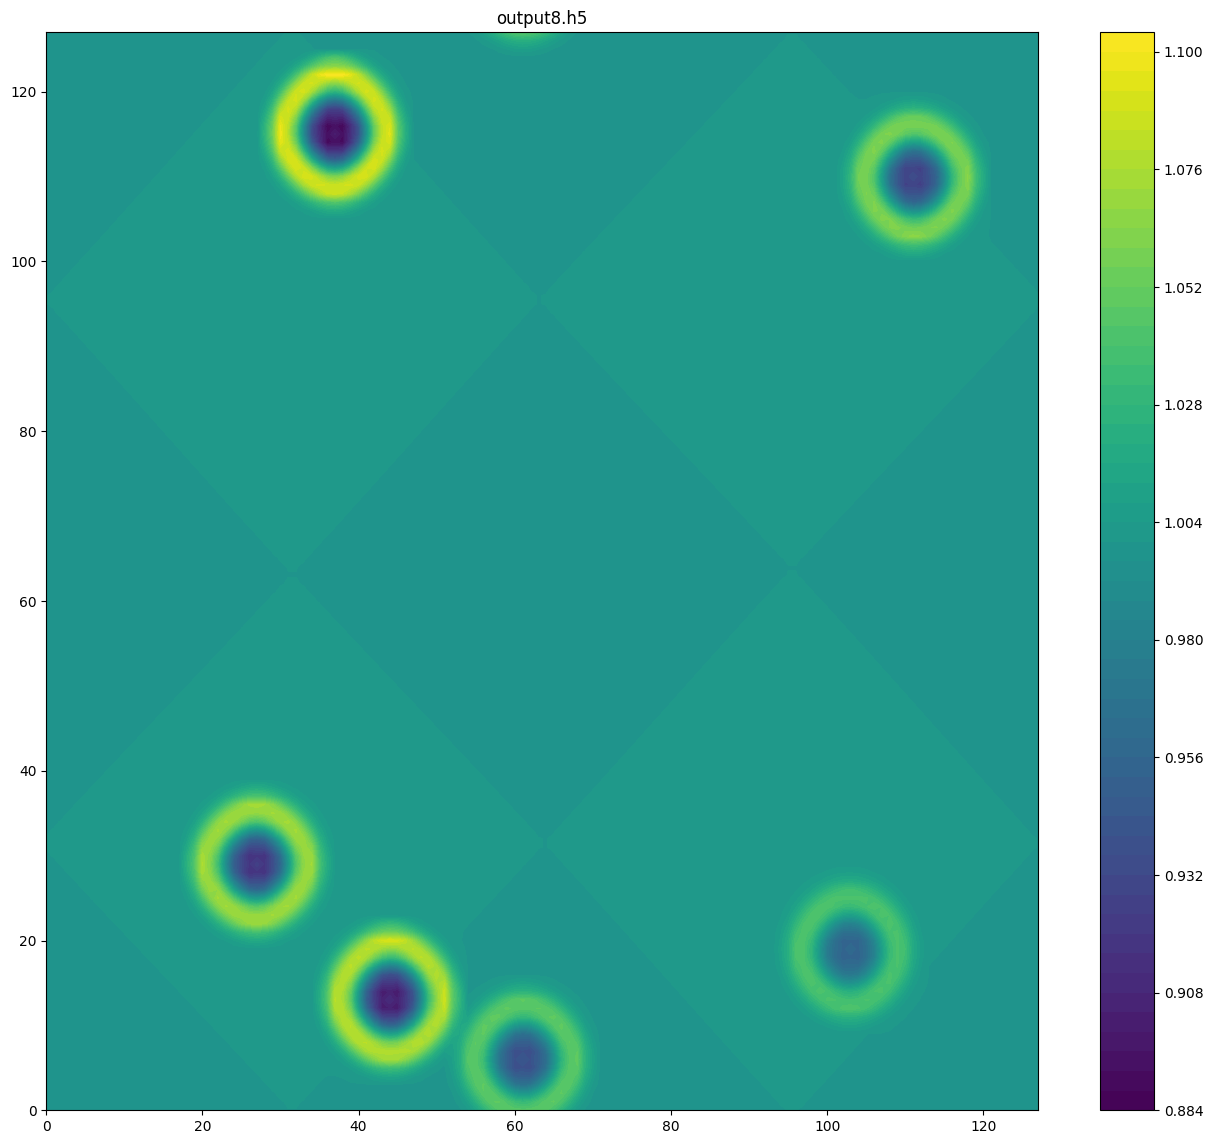

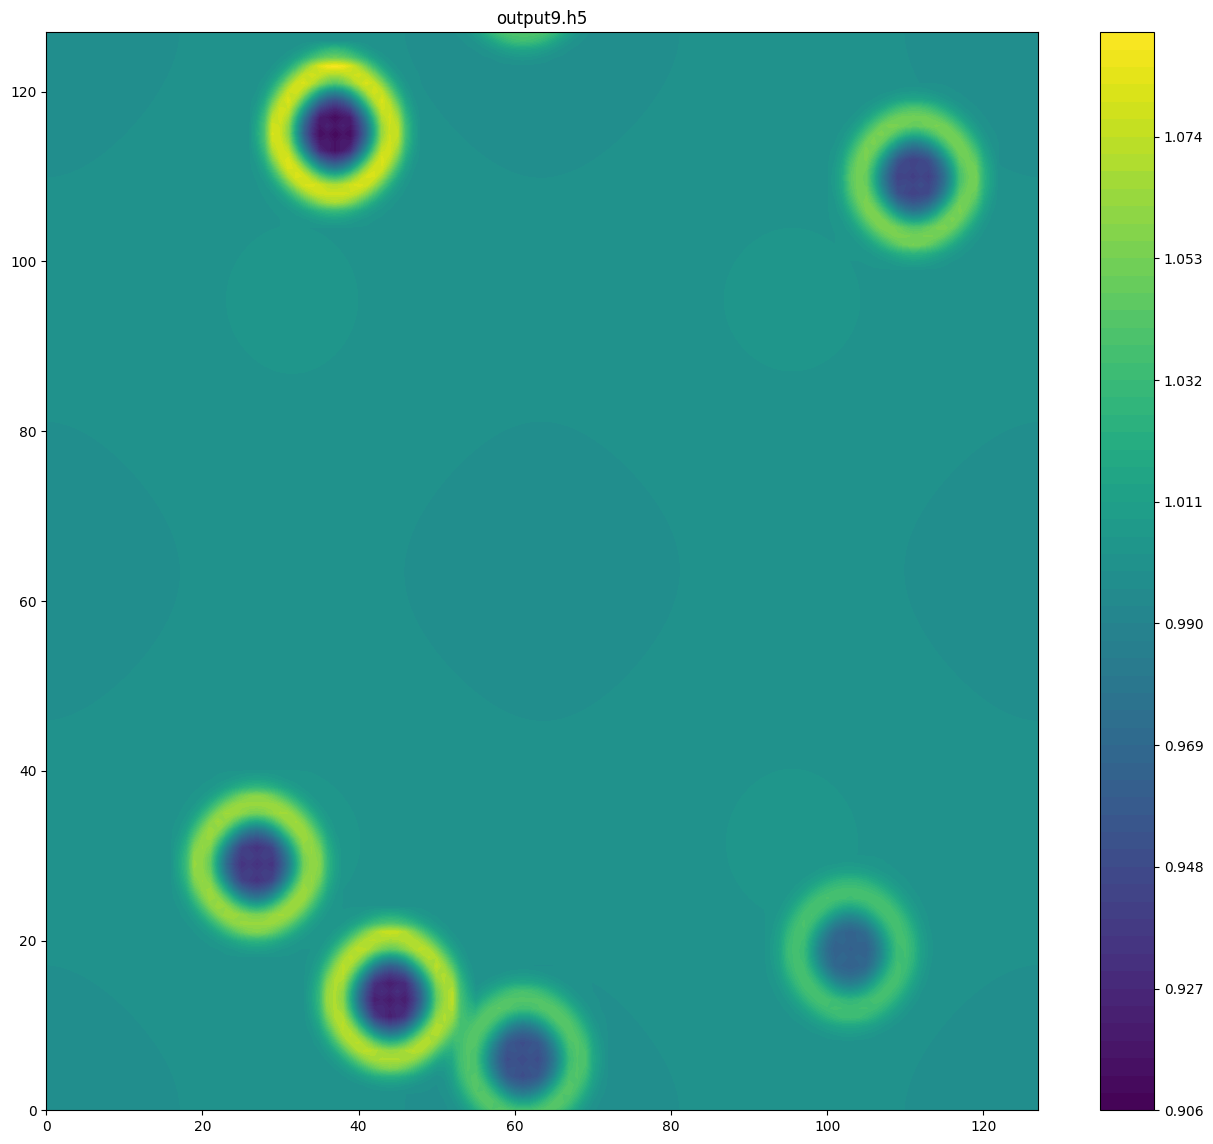

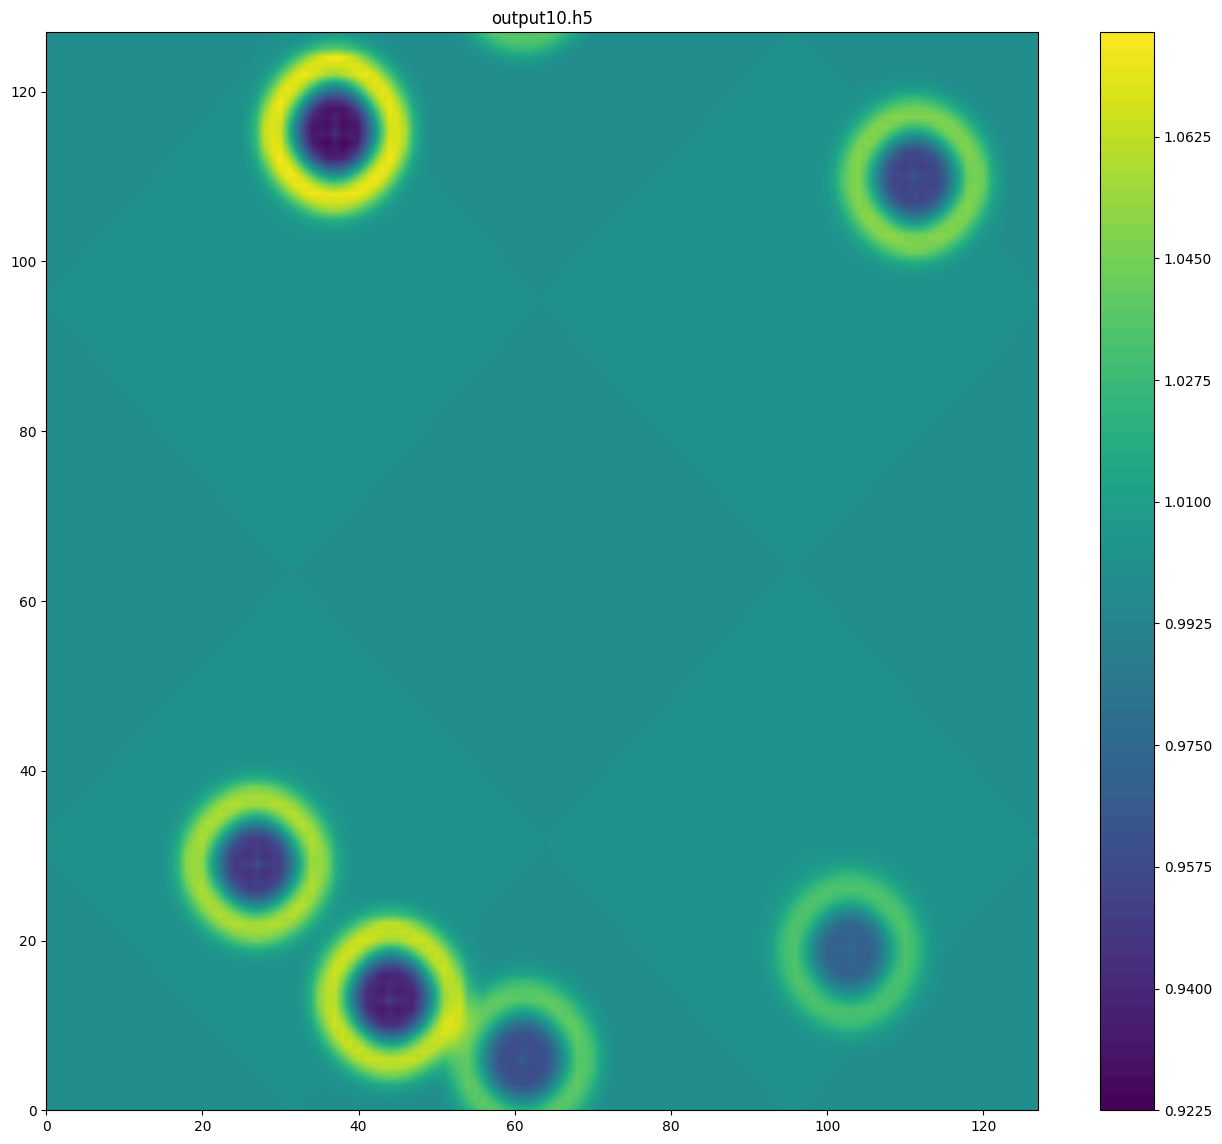

In [135]:
def plotscal(f, i):
    _ = plt.figure(i, figsize=[16,14])
    _ = plt.contourf(f[i,:,:], 64)
    _ = plt.colorbar()
    _ = plt.title(names[i])

def plotfield(fx, fy, field, i):
    fac=1
    mod = fx*fx+fy*fy
    x,y = np.meshgrid(np.linspace(0,Nx-1,int(Nx/fac)),np.linspace(0,Ny-1,int(Nx/fac)))
    _ = plt.figure(i, figsize=[16,14])
    #_ = plt.contourf(mod[i,:,:], 255)
    _ = plt.contourf(field[i,:,:], 255)
    _ = plt.colorbar()
    _ = plt.quiver(x,y,fx[i,::fac,::fac],fy[i,::fac,::fac], scale=2)
    _ = plt.title(names[i])

for i in range(T):
    #plotscal(divV, i)
    plotscal(rho,i)
    #plotfield(ux, uy, divV, i)